isodes: 33
Reward after 352 episodes: 51
Reward after 353 episodes: 84
Reward after 354 episodes: 72
Reward after 355 episodes: 55
Reward after 356 episodes: 177
Reward after 357 episodes: 113
Reward after 358 episodes: 76
Reward after 359 episodes: 39
Reward after 360 episodes: 160
Reward after 361 episodes: 108
Reward after 362 episodes: 199
Reward after 363 episodes: 77
Reward after 364 episodes: 113
Reward after 365 episodes: 129
Reward after 366 episodes: 146
Reward after 367 episodes: 130
Reward after 368 episodes: 199
Reward after 369 episodes: 143
Reward after 370 episodes: 128
Reward after 371 episodes: 139
Reward after 372 episodes: 199
Reward after 373 episodes: 140
Reward after 374 episodes: 166
Reward after 375 episodes: 118
Reward after 376 episodes: 100
Reward after 377 episodes: 89
Reward after 378 episodes: 85
Reward after 379 episodes: 199
Reward after 380 episodes: 127
Reward after 381 episodes: 147
Reward after 382 episodes: 64
Reward after 383 episodes: 99
Reward a

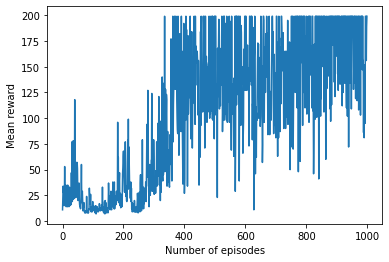

In [1]:
#-----------------------------------
# Author: Sneha Reddy Aenugu
# Description: Cartpole balancing
# with spiking agent actor-critic
#----------------------------------

import numpy as np
import math
import argparse
import random
import itertools
import pdb
from matplotlib import pyplot as plt
import pickle
import gym

#Constants

mod_F = 10
m_c = 1
m_p = 0.1
l = 0.5
td = 0.02
g = 9.8


class ActorCritic():
    def __init__(self, order, epsilon, step_size, sigma=0.1, num_states=4, radial_sigma=None):
        self.num_states = num_states
        self.epsilon = epsilon
        self.alpha = step_size
        self.sigma = sigma
        #self.cartpole = CartPole()
        self.cartpole = gym.make("CartPole-v0")
        self.order = order
        self.lda = 0.5
        self.w = {}

        self.w[-1] = 5*np.ones(int(math.pow(order+1, num_states)))
        self.w[1] = 5*np.ones(int(math.pow(order+1, num_states)))
        
        self.combns = np.array(list(itertools.product(range(order+1), repeat=num_states)))
        self.x_lim = [-3,3]
        self.v_lim = [-10,10]
        self.theta_lim = [-math.pi/2,math.pi/2]
        self.omega_lim = [-math.pi, math.pi]
        self.actors = [SpikingActor() for i in range(10)]


    def fourier_feature_state(self, state, method='fourier'):
        state_norm = np.zeros(self.num_states)
        state_norm[0] = (state[0]+self.x_lim[1])/(self.x_lim[1]-self.x_lim[0])
        state_norm[1] = (state[1]+self.v_lim[1])/(self.v_lim[1]-self.v_lim[0])
        state_norm[2] = (state[2]+self.theta_lim[1])/(self.theta_lim[1]-self.theta_lim[0])
        state_norm[3] = (state[3]+self.omega_lim[1])/(self.omega_lim[1]-self.omega_lim[0])

        prod_array = np.array([np.dot(state_norm, i) for i in self.combns])
        features = np.array(np.cos(np.pi*prod_array))
        return features


    def e_greedy_action(self, action_ind):
        prob = (self.epsilon/2)*np.ones(2)
        prob[action_ind] = (1 - self.epsilon) + (self.epsilon/2)
        #e_action = 2*np.random.choice(2,1,p=prob)-1
        pr_array = np.concatenate((np.ones(int(100*prob[1])), -1*np.ones(int(100*prob[0]))))
        e_action = pr_array[random.randint(0, len(pr_array)-1)]
        return int(e_action)


    def softmax_selection(self, qvalues, sigma):
        eps = 1e-5
        qvalues = qvalues + eps
        prob = np.exp(sigma*qvalues)/sum(np.exp(sigma*qvalues))
        prob[1] = 1-prob[0]
        e_action = 2*np.random.choice(2,1,p=prob)-1
        return int(e_action)


    def run_actor_critic(self, num_episodes, features='fourier'):
        rewards = []
        #theta = np.random.rand(self.num_states)
        #theta = np.zeros(self.num_states)
        theta = np.zeros(int(math.pow(self.order+1, self.num_states)))
        w_v = np.zeros(int(math.pow(self.order+1, self.num_states)))
        alpha = 0.001
        for i in range(num_episodes):
            #if i > 500:
            #    self.alpha = 0.001
            #state = np.zeros(4)
            state = self.cartpole.reset()
            e_theta = np.zeros_like(theta)
            e_v = np.zeros(int(math.pow(self.order+1, self.num_states)))
            rt = 1; gamma = 1
            count = 0
            sigma = 1
            while abs(state[0]) < 3 and abs(state[2]) < math.pi/2 and abs(state[3]) < math.pi and count < 1010:
                # Act using actor
                fourier_state = self.fourier_feature_state(state, features)
                state_param = np.dot(theta, fourier_state)

                o_rates = []
                for k in range(len(self.actors)):
                    o_spikes = self.actors[k].forward(state, count)
                    o_rates.append(o_spikes)
                o_rates = np.array(o_rates)
                action_rates = np.zeros(2)
                for k in range(2):
                    action_rates[k] = sum(o_rates[np.where(o_rates[:,k]==1),k][0])
                action_index = np.argmax(action_rates)
                action = self.e_greedy_action(action_index)

                new_state, reward, done, _ = self.cartpole.step(int((action+1)/2))
                fourier_state = self.fourier_feature_state(state, features)
                fourier_new_state = self.fourier_feature_state(new_state, features)

                # Critic update
                e_v = gamma*self.lda*e_v + fourier_state
                v_s = np.dot(w_v, fourier_state)
                v_ns = np.dot(w_v, fourier_new_state)
                delta_t = rt + gamma*v_ns - v_s
                w_v += alpha*delta_t*e_v

                # Actor update

                for k in range(len(self.actors)):
                    self.actors[k].update_weights(delta_t, state, int((action+1)/2), np.mean(rewards[-10:]))

                if done:
                    break

                state = new_state
                count += 1

            print("Reward after %s episodes: %s" %(i, count))
            rewards.append(count)
        return rewards

class SpikingActor():
    def __init__(self):
        self.inputs = 4
        self.hidden = 200
        self.outputs = 2
        self.ih_weights = 0.01*np.random.rand(2, self.hidden, self.inputs)
        self.ih_bias = np.random.rand(self.hidden)
        self.ho_weights = 0.01*np.random.rand(self.outputs, self.hidden)
        self.ho_bias = np.random.rand(self.outputs)
        self.alpha = 0.001
        self.h_spikes = np.ones(self.hidden)
        self.o_spikes = np.ones(self.outputs)
        self.in_spikes = np.ones(self.inputs)
        self.hz = np.zeros(self.hidden)
        self.oz = np.zeros(self.outputs)

    def input_coding(self, state):
        maps = list(itertools.combinations(range(int(self.inputs*0.25)), r=int(self.inputs*0.25*0.5)))
        state_code = -1*np.ones(self.inputs)
        xb = int(self.inputs*0.25*(state[0] + 3)/6)
        vb = int(self.inputs*0.25*(state[1] + 10)/20)
        thetab = int(self.inputs*0.25*(state[0] + math.pi/2)/math.pi)
        omegab = int(self.inputs*0.25*(state[1] + math.pi)/(2*math.pi))
        state_code[list(maps[xb])] = 1
        state_code[list(np.array((maps[vb])) + int(self.inputs*0.25))] = 1
        state_code[list(np.array((maps[thetab])) + int(self.inputs*0.5))] = 1
        state_code[list(np.array((maps[omegab])) + int(self.inputs*0.75))] = 1
        return state_code


    def forward(self,state,count):
        inputs = state
        self.in_spikes = state

        self.hz = np.zeros((2, self.hidden))
        self.h_spikes = np.ones((2, self.hidden))
        for i in range(2):
            z = np.matmul(self.ih_weights[i], inputs)
            p = 1/(1 + np.exp(-2*z))
            self.h_spikes[i] = (p > np.random.rand(self.hidden)).astype(int)
            self.h_spikes[i] = 2*self.h_spikes[i] - 1
            self.hz[i] = 1 + np.exp(2*z*self.h_spikes[i])


        self.oz = np.zeros(self.outputs)
        self.o_spikes = np.ones(self.outputs)

        for i in range(2):
            zo = np.dot(self.ho_weights[i], self.h_spikes[i])
            po = 1/(1 + np.exp(-2*zo))
            self.o_spikes[i] = (po > np.random.rand(1)).astype(int)
            self.o_spikes[i] = 2*self.o_spikes[i] - 1
            self.oz[i] = 1 + np.exp(2*zo*self.o_spikes[i])

        return self.o_spikes

    def update_weights(self, tderror, state, action, mean_reward):

        if mean_reward > 70 and mean_reward < 190:
            self.alpha = 0.00001
        elif mean_reward > 190:
            self.alpha = 0.00001
        else:
            self.alpha = 0.001

        for i in range(2):
            if i == action:
                self.ih_weights[i] += self.alpha*tderror*np.outer(2*self.h_spikes[i]/self.hz[i], self.in_spikes)
            else:
                if self.o_spikes[i] == 1:
                    self.ih_weights[i] -= self.alpha*tderror*np.outer(2*self.h_spikes[i]/self.hz[i], self.in_spikes)
                else:
                    self.ih_weights[i] += self.alpha*tderror*np.outer(2*self.h_spikes[i]/self.hz[i], self.in_spikes)


        for i in range(2):
            if i == action:
                self.ho_weights[i] += self.alpha*tderror*np.multiply(2*self.o_spikes[i]/self.oz[i], self.h_spikes[i])
            else:
                if self.o_spikes[i] == 1:
                    self.ho_weights[i] -= self.alpha*tderror*np.multiply(2*self.o_spikes[i]/self.oz[i], self.h_spikes[i])
                else:
                    self.ho_weights[i] += self.alpha*tderror*np.multiply(2*self.o_spikes[i]/self.oz[i], self.h_spikes[i])



class Args:
    algorithm = 'sarsa'
    features = 'fourier'
    selection = 'egreedy'
    num_trials = 1
    num_episodes = 1000
    plot = True

if __name__ == "__main__":

    args = Args()


    rewards_trials = []


    step_size = 0.001 # Sarsa, fourier 0.001
    epsilon = 0.1
    

    for i in range(int(args.num_trials)):
        print('Trial:', i)
        td_cp = ActorCritic(order=5, epsilon=epsilon, step_size=step_size, num_states=4)
        rewards = td_cp.run_actor_critic(int(args.num_episodes), features='fourier')
        rewards_trials.append(rewards)


    if args.plot:
        episodes = np.linspace(0,int(args.num_episodes)-1,int(args.num_episodes))
        rewards_mean = np.mean(rewards_trials, axis=0)
        rewards_std = np.std(rewards_trials, axis=0)
        plt.errorbar(episodes, rewards_mean, rewards_std)
        plt.ylabel('Mean reward')
        plt.xlabel('Number of episodes')
        plt.show()

    f = open('rewards_ac.pkl', 'wb')
    pickle.dump(rewards_trials, f)

In [22]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()

Rm = rewards_mean
mean_rewards = []
std_rewards = []
for i in range(len(Rm)):
    mean_rewards.append(np.mean(Rm[:(i+1)]))
    std_rewards.append(np.std(Rm[:(i+1)]))
mean_rewards = np.array(mean_rewards)
std_rewards = np.array(std_rewards)

p0 = figure(
    title = "Rewards (Cartpole)",
    x_axis_label = "Episodes",
    y_axis_label = "Rewards"
)
p0.line(x=episodes, y=Rm, line_width=2)

p1 = figure(
    title = "Mean rewards (Cartpole)",
    x_axis_label = "Episodes",
    y_axis_label = "Mean Rewards"
)
p1.line(x=episodes, y=mean_rewards, line_width=2)

p2 = figure(
    title = "Standard deviation of rewards (Cartpole)",
    x_axis_label = "Episodes",
    y_axis_label = "Standard Deviation of Rewards"
)
p2.line(x=episodes, y=std_rewards, line_width=2, color='red')

Loading BokehJS ...

GlyphRenderer(id='3384', ...)

In [23]:
show(p0)

In [24]:
show(p1)

In [25]:
show(p2)